In [1]:
import logging
import sys
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))

from lib.power_system import PowerDistributionManagementSystem, SolarFarm, KRUSTYReactor, Battery
from lib.storage_tank import StorageTank
from lib.atmosphere_intake_system import AtmosphereIntakeSystem

# Set up logging
logging.basicConfig(
    filename='simulation.log',
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set up Seaborn for better visuals
sns.set_theme(style="whitegrid")

In [2]:
solar_farm = SolarFarm(
    name='Solar Farm',
    max_output_kw=100,
    efficiency=0.2,
    martian_year_hours=24 * 668.6,
    on_duration=12,
    off_duration=12,
)

krusty_reactors = [
    KRUSTYReactor(
        name='KRUSTY-1',
        max_output_kw=10,
        efficiency=0.5,
        burnup_rate=0.0001,
        operational_uptime=0.8,
        maintenance_schedule=[0, 100, 200, 300, 400, 500, 600, 700],
    ),
    KRUSTYReactor(
        name='KRUSTY-2',
        max_output_kw=10,
        efficiency=0.5,
        burnup_rate=0.0001,
        operational_uptime=0.8,
        maintenance_schedule=[0, 100, 200, 300, 400, 500, 600, 700],
    ),
]
battery = Battery(capacity_kj=1e5, level_kj=0.5e4, charge_efficiency=0.9, discharge_efficiency=0.9, degradation_rate=0.0001)
pdms = PowerDistributionManagementSystem(solar_farm, krusty_reactors, battery)
pdms

In [3]:
CO2_tank = StorageTank(
    name='CO2 Tank',
    capacity_grams=1e6,
    level_grams=1e2,
)

atmosphere_intake = AtmosphereIntakeSystem(
    name='Atmosphere Intake',
    power_demand_kj=1e4,
    criticality_level=1,
    operational_hours=[0, 6, 12, 18],
    CO2_tank=CO2_tank,
    max_flow_rate_grams_per_hour=1e4,
)

CO2_tank, atmosphere_intake

(<lib.storage_tank.StorageTank at 0x12071d4f0>,
 AtmosphereIntakeSystem(name='Atmosphere Intake', power_demand_kj=10000.0, criticality_level=1, operational_hours=[0, 6, 12, 18]))

In [4]:
subsystems = [atmosphere_intake]
for subsystem in subsystems:
    pdms.add_subsystem(subsystem)

total_simulation_hours = 1000
for hour in range(total_simulation_hours):
    pdms.distribute_power(hour)
    if not pdms.is_subsystem_in_load_shedding("Atmosphere Intake System", hour):
        atmosphere_intake.run_cycle(hour)

    # At a random hour empty the CO2 tank
    if np.random.rand() < 0.01:
        CO2_tank.remove(CO2_tank.level_grams, hour)

In [5]:
# After simulation, access the metrics DataFrame
display(pdms.metrics)
display(CO2_tank.metrics)
display(atmosphere_intake.metrics)

,hour,total_generation_kj,total_consumption_kj,battery_soc,load_shedding
0,0,75741.610022,10000.0,0.641674,
1,1,147196.000871,0.0,1.000000,
2,2,150478.892451,0.0,1.000000,
3,3,72863.363050,0.0,1.000000,
4,4,136032.845374,0.0,1.000000,
...,...,...,...,...,...
995,995,95374.735932,0.0,1.000000,
996,996,64828.800000,10000.0,1.000000,
997,997,32410.800000,0.0,1.000000,
998,998,64814.400000,0.0,1.000000,


,hour,level_grams,percentage_full,pressure_kilo_pascal
0,0,10100.0,0.0101,NaN
1,1,20100.0,0.0201,NaN
2,2,30100.0,0.0301,NaN
3,3,40100.0,0.0401,NaN
4,4,50100.0,0.0501,NaN
...,...,...,...,...
563,989,960000.0,0.9600,NaN
564,990,970000.0,0.9700,NaN
565,991,980000.0,0.9800,NaN
566,992,990000.0,0.9900,NaN


,hour,co2_added_grams,power_used_kj
0,0,10000.0,10000.0
1,1,10000.0,10000.0
2,2,10000.0,10000.0
3,3,10000.0,10000.0
4,4,10000.0,10000.0
...,...,...,...
995,995,0.0,0.0
996,996,0.0,0.0
997,997,0.0,0.0
998,998,0.0,0.0


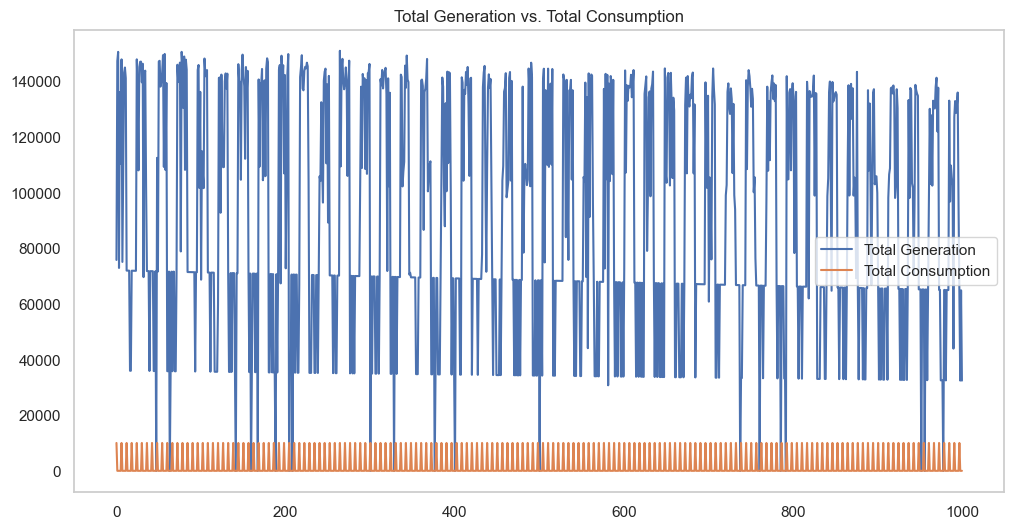

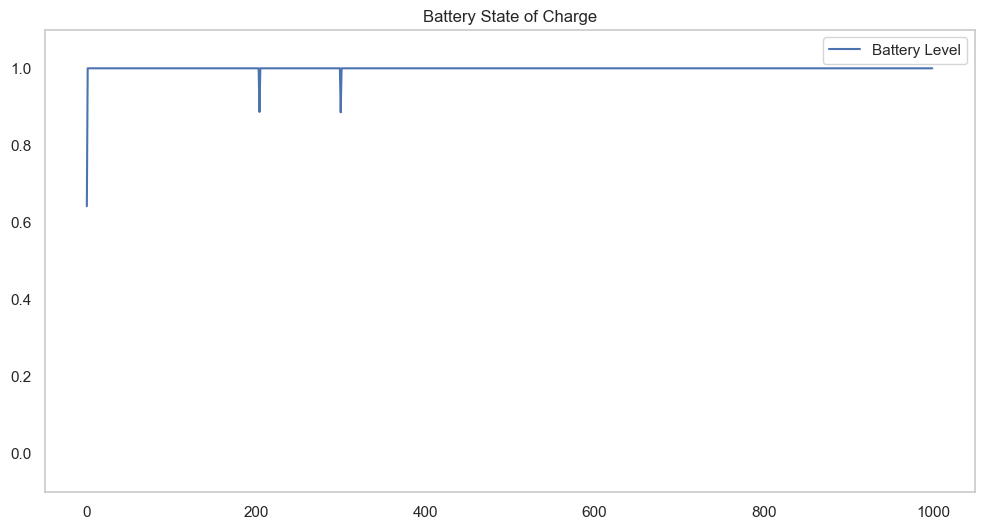

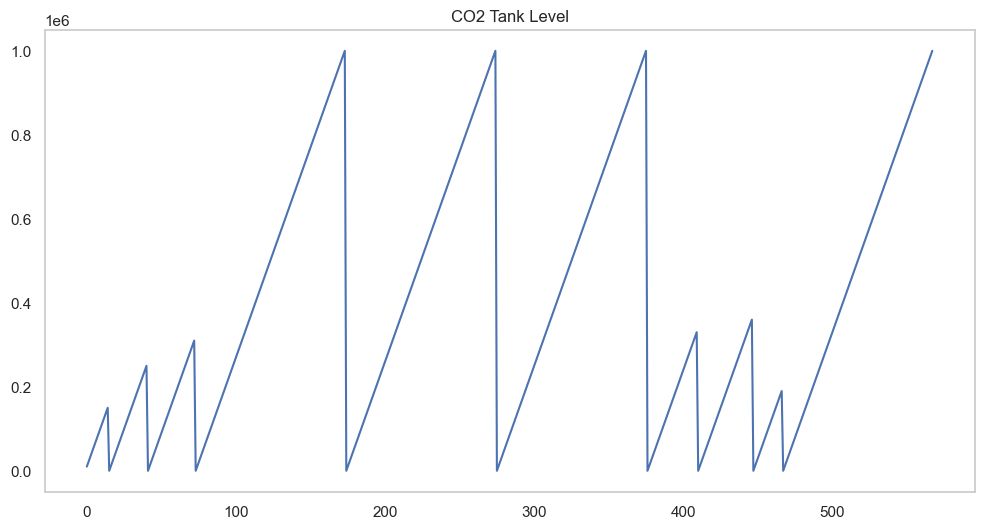

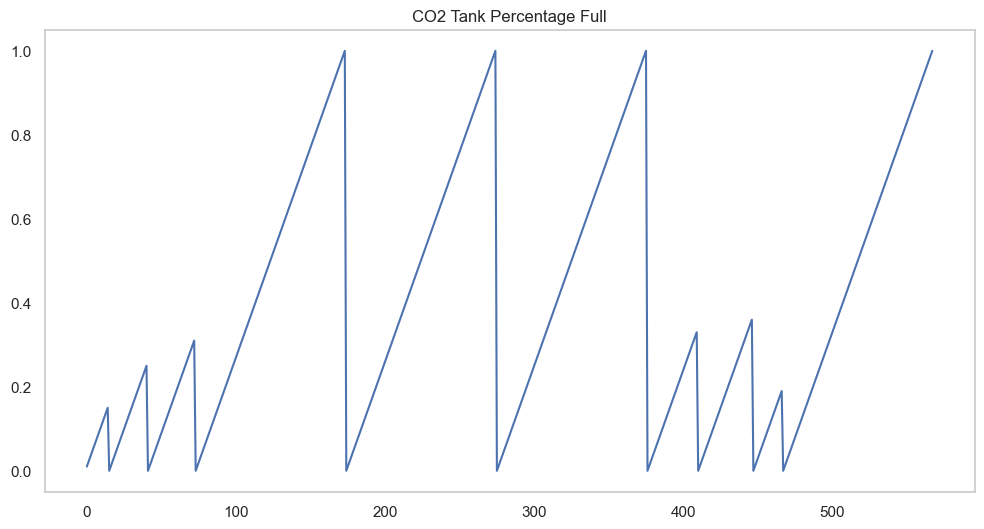

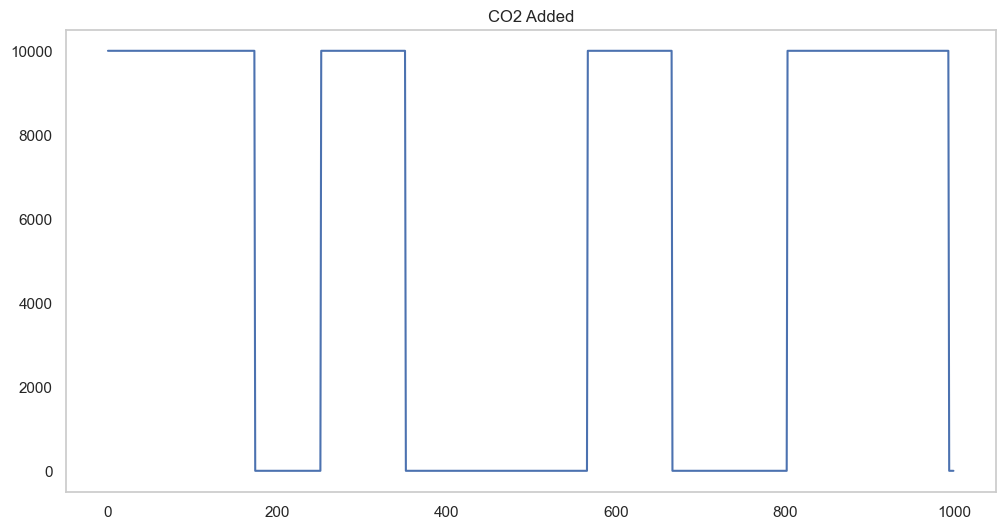

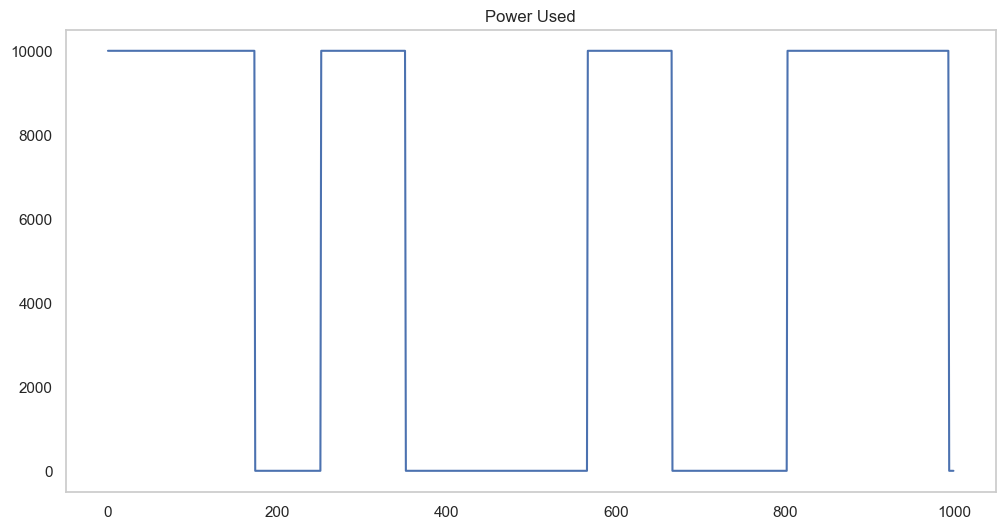

In [7]:
f = plt.figure(figsize=(12, 6))
pdms.metrics.total_generation_kj.plot(label='Total Generation')
pdms.metrics.total_consumption_kj.plot(label='Total Consumption')
plt.legend()
plt.title('Total Generation vs. Total Consumption')
plt.grid()
plt.show()

f = plt.figure(figsize=(12, 6))
pdms.metrics.battery_soc.plot(label='Battery Level')
plt.legend()
plt.ylim(-0.1, 1.1)
plt.title('Battery State of Charge')
plt.grid()
plt.show()

f = plt.figure(figsize=(12, 6))
CO2_tank.metrics.level_grams.plot(label='CO2 Tank Level')
plt.title('CO2 Tank Level')
plt.grid()
plt.show()

f = plt.figure(figsize=(12, 6))
CO2_tank.metrics.percentage_full.plot(label='CO2 Tank Percentage Full')
plt.title('CO2 Tank Percentage Full')
plt.grid()
plt.show()

f = plt.figure(figsize=(12, 6))
atmosphere_intake.metrics.co2_added_grams.plot(label='CO2 Added')
plt.title('CO2 Added')
plt.grid()
plt.show()

f = plt.figure(figsize=(12, 6))
atmosphere_intake.metrics.power_used_kj.plot(label='Power Used')
plt.title('Power Used')
plt.grid()
plt.show()